*Reva Bharara*

*Email : revabharara@gmail.com, bhararareva@gmail.com*

*Linkedin : https://www.linkedin.com/in/reva-bharara-a83a78241/*


### Objective: To make a movie recommendation system based on collaborative filtering using K means clustering.

### *Index:*
1. Importing the dependencies
2. Importing relevant datasets
3. Data exploration
4. Data preprocessing
5. Data analysis
5. Collaborative filtering recommendation system (K-Means)
    1. Forming a movie and user rating matrix so that we can easily cluster the similar users (using pivot table)
    2. K Means clustering (building the model)
    3. Training the model and visualisation
    4. Evaluating the model
6. Insights
7. Credits

### --------------------------------------------------------------------------------------------------------
### *1. Importing the dependencies*

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import silhouette_score
from scipy.sparse import csr_matrix


### --------------------------------------------------------------------------------------------------------
### *2. Importing relevant datasets*

In [2]:
# importing the movies dataset
df_movies=pd.read_csv('movie_names.csv')

# importing the rating dataset
df_rating=pd.read_csv('rating.csv')

In [3]:
# the dataset is too big so we will be cutting it short for smoother operations
# df_rating=df_rating.head(200000)
# df_rating.drop(['Unnamed: 0'], axis=1, inplace=True)
# df_rating.to_csv('rating.csv', index=False)

### --------------------------------------------------------------------------------------------------------
### *3. Exploring the data*

In [4]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_rating.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy


In [6]:
# let us look at the columns present in the datasets and their general features
print(df_movies.columns)
print(df_rating.columns)


Index(['movieId', 'title', 'genres'], dtype='object')
Index(['userId', 'movieId', 'rating', 'title', 'genres'], dtype='object')


In [7]:
print(f'shape of movies dataset: {df_movies.shape}')
print(f'shape of rating dataset: {df_rating.shape}')

shape of movies dataset: (27278, 3)
shape of rating dataset: (200000, 5)


In [8]:
print(f'info about the movies dataset: {df_movies.info()}')
print()
print(f'info about the rating dataset: {df_rating.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
info about the movies dataset: None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   200000 non-null  int64  
 1   movieId  200000 non-null  int64  
 2   rating   200000 non-null  float64
 3   title    200000 non-null  object 
 4   genres   200000 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB
info about the rating dataset: None


In [9]:
df_rating.isnull().sum()

userId     0
movieId    0
rating     0
title      0
genres     0
dtype: int64

### --------------------------------------------------------------------------------------------------------
### *4. Data preprocessing*

#### There are no null values in both the dataframes so we dont have to process those.

#### We now need to join the *'title'* and *'genres'* column from df_movies to df_rating and store it


In [10]:
# df_rating=df_rating.merge(df_movies, on='movieId', how='inner')
# df_rating.head()

#### We don't need the timestamp column it is of no significance so we will delete it.

In [11]:
# df_rating.drop(['timestamp'],axis=1, inplace=True)
# df_rating.head()

#### I have already save the modified dataframe in the rating.csv so we dont need to merge and drop columns every time.
In case you are downloading the dataset from kaggle itself, uncomment the above two cells and run them to modify the dataframe.

In [12]:
len(df_rating['title'].unique())

10151

In [13]:
# checking if there are any null values still
df_rating.isnull().sum()

userId     0
movieId    0
rating     0
title      0
genres     0
dtype: int64

### --------------------------------------------------------------------------------------------------------
### *5. Data Analysis*

#### Now that we have explored and pre-processed the data, we will now analyse it in this section to gather any insights that might help up in out model building process. This involves:
1. finding the average user rating of each movie
2. finding the likebility of each genre
3. number of movies in each genre


#### 1. Finding the average user rating of each movie


In [14]:
df_rating.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy


In [15]:
df_avg_rating=df_rating.groupby('movieId')['rating'].mean()
df_avg_rating=df_avg_rating.reset_index()
df_avg_rating.head()

,movieId,rating
0,1,4.013771
1,2,3.285388
2,3,3.204000
3,4,3.041667
4,5,3.124031


#### 2. Finding the likeability of each genre

In [16]:
# seeing the number of unique values for genres in the table
len(df_rating['genres'].unique())

920

#### we know that there are more than 1 genres associated with the movies, therefor to be able to find the likability of each genre we will need to split the genres and categorize movies in them. Then we shall review the ratings and see which genre performs the best

In [17]:
# creating a list that contains unique genres
genres=[]

# creating a list to store the split items 
genre_movie=[]

# splitting the content in genre column
for row in df_rating['genres']:
    genre_movie=row.split('|')
    
    for genre in genre_movie:
        if genre not in genres:
            genres.append(genre)

In [18]:
# all the genres in the dataframe
genres

['Adventure',
 'Children',
 'Fantasy',
 'Drama',
 'Mystery',
 'Sci-Fi',
 'Thriller',
 'Crime',
 'Action',
 'Comedy',
 'Romance',
 'War',
 'Horror',
 'Musical',
 'Western',
 'Animation',
 'IMAX',
 'Film-Noir',
 'Documentary',
 '(no genres listed)']

### Here we created a dataframe that tell us where a movie belongs to a perticular genre or not using the get_dummies. This is crucial as we will be able to tell the likability of each genre after we split the genres and then group the ratings based on those individual genres.

In [19]:
# data frame containing all the info except the genre
df_info= df_rating.drop(['genres'], axis=1)

# dataframe containg the dummies created on the genre column
df_dummies=df_rating['genres'].str.get_dummies(sep='|')

# final dataframe
df_final=pd.concat([df_info,df_dummies], axis=1)

df_final.head()

,userId,movieId,rating,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,2,3.5,Jumanji (1995),0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,5,2,3.0,Jumanji (1995),0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,13,2,3.0,Jumanji (1995),0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,29,2,3.0,Jumanji (1995),0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,34,2,3.0,Jumanji (1995),0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Now for each individual genre we will be finding the average rating.

In [20]:
genre_rating_value=[]
for genre in genres:
    avg_rate=df_final.loc[df_final[genre]==1]['rating'].mean()
    genre_rating_value.append(avg_rate)

# converting the dict into dataframe
df_genre_rating=pd.DataFrame({'genre':genres,'rating average':genre_rating_value})
df_genre_rating.sort_values('rating average', ascending=False)

,genre,rating average
17,Film-Noir,3.977295
11,War,3.815907
18,Documentary,3.743519
7,Crime,3.673462
16,IMAX,3.663727
4,Mystery,3.661554
3,Drama,3.659290
15,Animation,3.584332
14,Western,3.529826
10,Romance,3.521331


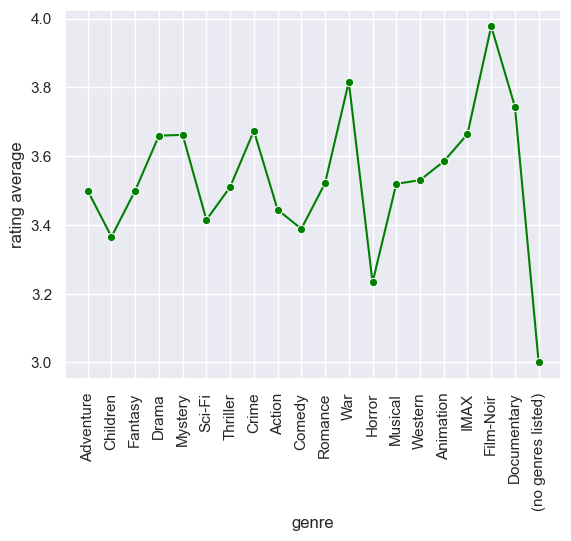

In [21]:
sns.set()
sns.lineplot(x='genre', y='rating average', data=df_genre_rating, marker='o', color='green')
plt.xticks(rotation=90)
plt.show()

### from this graph and the dataframe we can gather the following insights:
1. The top liked genres are:
    1. Film-Noir (3.977295)
    2. War (3.815907)
    3. Documentary	(3.743519)
    
2. The least liked genres are:
    1. Horror (3.232296)
    2. Children	(3.365155)
    3. Comedy (3.388250)

#### 3. Number of movies in each genre

In [22]:
genre_movie_count=[]
for genre in genres:
    movie_count=df_final.loc[df_final[genre]==1]['movieId'].count()
    genre_movie_count.append(movie_count)

# converting the dict into dataframe
df_movie_count=pd.DataFrame({'genre':genres,'number of movies':genre_movie_count})
df_movie_count.sort_values('number of movies', ascending=False)

,genre,number of movies
3,Drama,86449
9,Comedy,75597
8,Action,56574
6,Thriller,53535
0,Adventure,43703
10,Romance,37598
7,Crime,32520
5,Sci-Fi,32054
2,Fantasy,21010
1,Children,16519


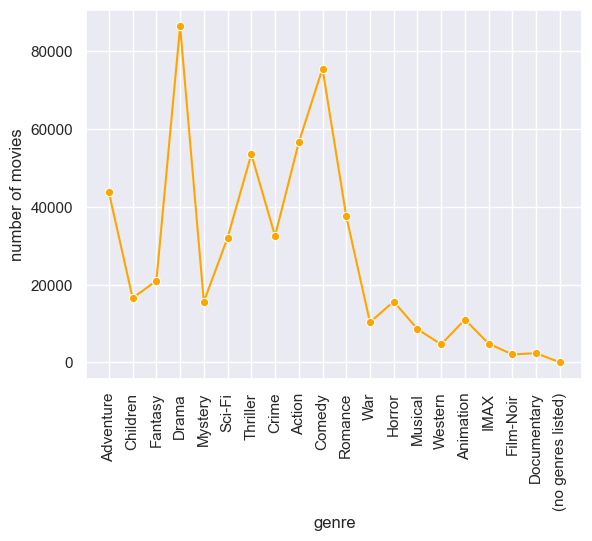

In [23]:
sns.lineplot(x='genre', y='number of movies', data=df_movie_count, marker='o', color='orange')
plt.xticks(rotation=90)
plt.show()

### from this graph and the dataframe we can gather the following insights:
1. Highest number of movies belong to the genre:
    1. Drama	86449
    2. Comedy	75597
    3. Action	56574
    
2. The least number of movies belong to the genres:
    1. Film-Noir	2026
    2. Documentary	2353
    3. Western	4610

### --------------------------------------------------------------------------------------------------------
### *5. Collaborative movie recommendation system*

The current content-based recommendation engine we have has significant limitations. It can only suggest movies that are similar to a particular movie and cannot provide recommendations across different genres or capture individual preferences. Additionally, the engine does not take into account the unique tastes and biases of individual users, as it provides the same recommendations to all users who query it for a particular movie.

To overcome these limitations, we will use a technique called Collaborative Filtering, which uses the behavior and preferences of similar users to predict how much a user will like a particular movie that they have not yet watched. This approach leverages the idea that users who have similar preferences can be used to make accurate recommendations and tailor them to each user's individual tastes.

In this collaborative filtering system we will be creating a user-movie rating matrix that will tell us how users rated every movie and from there we will be using the nearest neighbor model to form user clusters and based on those user clusters we will be recommending the movies.
This matrix will tell us how the users have rated a particular movie

In this section we will be 
1. Forming a movie and user rating matrix so that we can easily cluster the similar users (using pivot table)
2. K Means clustering (building the model)
3. Training the model and visualisation
4. Evaluating the model

## 1. Forming the pivot table

In [24]:
rating_pivot=df_rating.pivot_table(columns='userId', index='title', values='rating')
rating_pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,...,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371
title,,,,,,,,,,,,,,,,,,,,,
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Neath the Arizona Skies (1934),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Since we cannot process nan values we are going to change them to 0.0

In [25]:
rating_pivot.fillna('0.0', inplace=True)
rating_pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,...,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371
title,,,,,,,,,,,,,,,,,,,,,
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Neath the Arizona Skies (1934),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
rating_pivot[1].unique()

array(['0.0', 3.5, 4.0, 3.0, 5.0, 4.5], dtype=object)

In [27]:
#converting the dtype of values into float
rating_pivot=rating_pivot.astype('float')

In [28]:
rating_pivot[1].dtype

dtype('float64')

#### Now since there are a lot of 0 values and they will have no impact on k means clustering (using eucludian distance) to make it more efficint we will be converting the pivot table into a sparce matrix using the scipy module and csr_matrix function.
The SciPy library provides a module called scipy.sparse that implements various types of sparse matrices. One of these matrix formats is the Compressed Sparse Row (CSR) format, which is commonly used for sparse matrix operations in numerical computations.

In [29]:
rating_pivot=csr_matrix(rating_pivot)
rating_pivot

<10151x1371 sparse matrix of type '<class 'numpy.float64'>'
	with 199997 stored elements in Compressed Sparse Row format>

## 2. KMeans clustering
We can group users based on their movie ratings using a user-item rating matrix, where each row represents me as a user and each column represents a movie, with the values in the matrix representing my rating for the corresponding movie.

By treating each row as a data point and using k-means clustering, I can group similar users together based on their ratings, choosing the number of clusters with the elbow method. 

Once the users have been clustered, you can recommend movies to new users by suggesting movies that have been highly rated by users in the same cluster. This approach assumes that users in the same cluster have similar movie preferences, and therefore, are likely to enjoy the same movies.

In [30]:
# initializing the model
kmeans=KMeans(init='k-means++', n_clusters=5, n_init=12)
kmeans

KMeans(n_clusters=5, n_init=12)

In [31]:
# training the model
clusters=kmeans.fit(rating_pivot)
clusters

KMeans(n_clusters=5, n_init=12)

In [51]:
# the true labels of the fitted model
labels=clusters.labels_
np.unique(labels)

array([0, 1, 2, 3, 4])

In [35]:
# the cluster centers
clusters.cluster_centers_

array([[1.88561721e-02, 1.01925255e-02, 1.08720272e-02, ...,
        2.62740657e-02, 1.81200453e-03, 6.79501699e-04],
       [2.52217997e-01, 1.07731305e-01, 5.15842839e-01, ...,
        3.53612167e-01, 5.70342205e-02, 4.68948035e-02],
       [1.75287356e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.58045977e-01, 1.29310345e-02],
       [5.89285714e-01, 2.50000000e-01, 9.46428571e-01, ...,
        1.39285714e+00, 5.62500000e-01, 9.82142857e-01],
       [1.52734375e+00, 4.29687500e-01, 1.67968750e+00, ...,
        5.39062500e-01, 8.67187500e-01, 2.53906250e-01]])

### we have taken the initial number of clusters as 5 but it might not be the most efficient one so we will look at different numbers of clusters and which values of the same gives us the best results. This is done using two evaluation methods:
1. elbow graph

In [70]:
# creating a list for  within cluster sum of squared distances
wcss=[]

for num_clusters in range (1,10):
    kmeans=KMeans(init='k-means++', n_clusters=num_clusters, n_init=12, random_state=42)
    kmeans.fit(rating_pivot)
    # wcss is the within cluster sum of squared distances from one point to all the other points
    # this method is used for finding the elbow graph
    wcss.append(kmeans.inertia_)   

In [103]:
wcss_list=list(enumerate(wcss, start=1))
wcss_array = np.array(wcss_list)
wcss_array

array([[1.00000000e+00, 2.56870416e+06],
       [2.00000000e+00, 2.27285464e+06],
       [3.00000000e+00, 2.17931881e+06],
       [4.00000000e+00, 2.13046571e+06],
       [5.00000000e+00, 2.09594033e+06],
       [6.00000000e+00, 2.06495255e+06],
       [7.00000000e+00, 2.04546638e+06],
       [8.00000000e+00, 2.02279665e+06],
       [9.00000000e+00, 2.01185768e+06]])

#### let us now plot the results to see where the wcss reaches the minimum so that we can find the best number of clusters


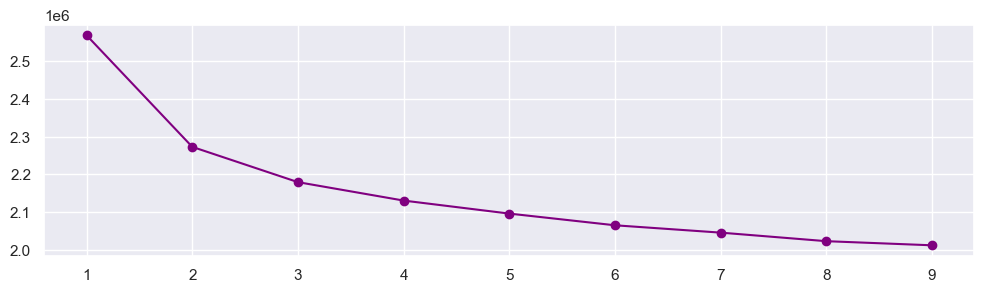

In [110]:
fig=plt.figure(figsize=(12,3))
plt.plot(wcss_array[:,0], wcss_array[:,1], color='purple', marker='o')
plt.show()

### From the above graph we can see that 5 can be chosen as an elbow point so we will put the values of clusters as 5 as we have already done above.

### --------------------------------------------------------------------------------------------------------
### *6. Insights*

From the above analysis and model development we gather the following insights:
1. The top liked genres are:
    1. Film-Noir (3.977295)
    2. War (3.815907)
    3. Documentary	(3.743519)
    
    
2. The least liked genres are:
    1. Horror (3.232296)
    2. Children	(3.365155)
    3. Comedy (3.388250)


3. Highest number of movies belong to the genre:
    1. Drama	(86449)
    2. Comedy	(75597)
    3. Action	(56574)
    
    
4. The least number of movies belong to the genres:
    1. Film-Noir	(2026)
    2. Documentary	(2353)
    3. Western	(4610)
    

#### We also saw the use of kmeans clustering to separate the users based on their rating on movies. On the basis of these clusters we can separate any new users that have similar interests to any cluster and recommend them movies.

#### The most efficient clustering was done when the number of clusters were 5.

#### We can improve the scope of the recommendation system by using hierarchical clustering which I will be working on in subsequent days.

### --------------------------------------------------------------------------------------------------------
### *7. Credits*

*Reva Bharara*

*Email : revabharara@gmail.com, bhararareva@gmail.com*

*Linkedin : https://www.linkedin.com/in/reva-bharara-a83a78241/*